## The Problem:


**Extracting all the locations of interest from an API that takes coordinates as inputs.**
Our endpoint only gives out 50 max results at a time (ordered by distance).

Looking into the Network tab in Developer Tools I found an API which takes coordinates(latitude / longitude) as input:

www.api_url.com/36.778261/-145.4179324/0/all (hiding the actual url)

This API, again, only gives out the 50 closest locations from a specific set of coordinates.

Below is a sample of one of those closest locations



In [ ]:
{
"TagsService": {
    "Accessor": {
            "Method": {
            #Commenting some fields for privacy concerns
            
        },
    "Target": {}
    },
    "Service": {}
},
    "Id": 0,
    "Center": "PLACE THAT I NEED TO SCRAPE",
    "Address": "1200 N STATE ST 2A",
    "City": "LOS ANGELES",
    "State": "CA",
    "ZIP": "90034",
    "ContactPerson": "",
    "PhoneNumber": "(323) 865-9999",
    "PhoneNumberPrefix": "",
    "PhoneNumber2": "",
    "PhoneNumber2Prefix": "",
    "Website": "",
    "CertificationStatus": "",
    "Latitude": 31.0487,
    "Longitude": -123.2084,
    "Distance": 3.8515551267394175,
    "distanceFromCurrent": "2.85",
    "order": "1",
    "XhtmlContent": null,
    "Tags": []
}

For my purposes, I'm only interested in the following fields:

    "Center": "PLACE THAT I NEED TO SCRAPE",
    "Address": "1200 N STATE ST 2A",
    "City": "LOS ANGELES",
    "State": "CA",
    "ZIP": "90034",
    "PhoneNumber": "(323) 865-9999",
    "Latitude": 31.0487,
    "Longitude": -123.2084,
    "Distance": 3.8515551267394175,
    "distanceFromCurrent": "2.85"  (this is in miles)
    

Given the API input (coordinates) and the available information in the API response, I try to come up with a solution for my problem.

My first thought was:

*  *Get a very large number of locations/coordinates in the US to call the API with.*

The drawback here is that I have no real way of knowing whether I'm getting all the results, or just most of them.

*  *For every coordinate I send to the API, I can use the value from the location that is furthest away (the value **distanceFromCurrent**) and I can cancel out an area around my coordinates with a radius at least as big*

What this means is that when I call the API again, I can use only the points that do not fall within that area, which I consider as being scanned already.

But how do I start generating coordinates? 
How do I cancel out those areas after I first my first "run" of calls to the API?
How do I generate coordinates again only in the spaces that are still unscanned?

A brief summary of the process:

1. Download/create a polygon of the US mapped with coordinates and overlay it over a map.
2. Create evenly distributed points over that map which will be used to call the API.
3. From the result of the first scan, create circled areas centered at the evenly distributed points with a radius of the furthest away point using **distanceFromCurrent**.
4. Make an intersection of the areas with the initial polygon (of the US).
5. Repeat the process over the leftover areas with a higher resolution (more densely-packed points) each time, until there is complete overlap between the areas and the initial polygon.
6. Take all the locations I have from making the API calls, keep only the unique locations, clean the data and save to an Excel file.
   
  


I used the libraries below:

* BeautifulSoup and lxml for parsing the xml file for the states' coordinates.
* pandas and geopandas to allow spatial operations on geometric types.
* NumPy has comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more.
* Geometric operations are performed by Shapely.
* Folium for mapping.

In [3]:
from bs4 import BeautifulSoup
import lxml
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
import folium
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.validation import explain_validity, make_valid
from shapely.prepared import prep
from shapely.ops import unary_union, transform
import shapely.wkt
import math
import copy
import time
from functools import partial
import pyproj



#### 1. Download/create a polygon of the US mapped with coordinates and overlay it over a map

While doing my research I found http://econym.org.uk/gmap/states.xml, which gives out the coordinates that make up the border of individual US States.

My idea was to make a giant polygon out of all of these, which would make up the US map.

Alabama as an example:

In [ ]:
<state name="Alabama" colour="#ff0000">
<point lat="35.0041" lng="-88.1955"/>
<point lat="34.9918" lng="-85.6068"/>
<point lat="32.8404" lng="-85.1756"/>
<point lat="32.2593" lng="-84.8927"/>
<point lat="32.1535" lng="-85.0342"/>
<point lat="31.7947" lng="-85.1358"/>
<point lat="31.5200" lng="-85.0438"/>
<point lat="31.3384" lng="-85.0836"/>
<point lat="31.2093" lng="-85.1070"/>
<point lat="31.0023" lng="-84.9944"/>
<point lat="30.9953" lng="-87.6009"/>
<point lat="30.9423" lng="-87.5926"/>
<point lat="30.8539" lng="-87.6256"/>
<point lat="30.6745" lng="-87.4072"/>
<point lat="30.4404" lng="-87.3688"/>
<point lat="30.1463" lng="-87.5240"/>
<point lat="30.1546" lng="-88.3864"/>
<point lat="31.8939" lng="-88.4743"/>
<point lat="34.8938" lng="-88.1021"/>
<point lat="34.9479" lng="-88.1721"/>
<point lat="34.9107" lng="-88.1461"/>
</state>

First I call the url with the .xml file, and parse it with BeautifulSoup.
From there I take all the point items and save their latitudes and longitudes in their respective arrays.

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36'}
response=requests.get("http://econym.org.uk/gmap/states.xml",headers=headers)
soup = BeautifulSoup(response.text, "lxml")
all_states=soup.find_all("state")
all_lats=[]
all_longs=[]
for i in all_states:
    all_points=soup.find_all("point")
    for point in all_points:
        all_lats.append(point['lat'])
        all_longs.append(point['lng'])

Initially I thought I could just join all the coordinates and create a single polygon with the Shapely Polygon method.

In [5]:
polygon_geom = Polygon(zip([float(i) for i in all_longs],
                           [float(i) for i in all_lats]))
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

Below is the geoDataframe with the polygon data and the polygon object respectively.

In [6]:
polygon

geometry
0  POLYGON ((-141.02050 70.01870, -141.72910 70.1...

In [7]:
polygon_geom

I can map these onto a real map using Folium, which can use a variety of objects, including geoDataframes and Shapely objects.

As I generate the map below, I can already see this is not going to work.


In [8]:
m = folium.Map([30.5454, -95.2627], zoom_start=2, tiles='cartodbpositron')
folium.GeoJson(polygon,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)

m

Firstly, this is not a single polygon, it is a bunch of intersecting lines which do not clearly delineate the US.

Secondly, I see Hawaii and Alaska are also in the polygon, but my initial check of the location website showed that there are no locations in those territories. This means they can be taken out to simplify the process.

I used Google maps to find a point between the Eastern part of Hawaii and the continental US, so I can have a longitude limit for my coordinates - and then replicating the process to get the latitude limit to Alaska.

In [9]:
soup = BeautifulSoup(response.text, "lxml")
all_states=soup.find_all("state")
all_lats=[]
all_longs=[]
myGeomList = []
count=0
for i in all_states:
    all_points=i.find_all("point")
    for point in all_points:
        if float(point['lat'])< 49.355022 and float(point['lng'])> -140.225210:
            all_lats.append(float(point['lat']))
            all_longs.append(float(point['lng']))

In [10]:
polygon_geom = Polygon(zip([float(i) for i in all_longs],
                           [float(i) for i in all_lats]))
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

In [11]:
m = folium.Map([30.5454, -95.2627], zoom_start=2, tiles='cartodbpositron')
folium.GeoJson(polygon,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)

m

After rendering my map again, I see we are getting closer, but we still have the problem of not having a unified polygon. The issue is that I'm trying to generate a polygon with a bunch of coordinates as a single shape, but in reality it consists of multiple polygons.

So instead I'll generate individual polygons for each US state, and then join them together as one.

This time, I create a list of geometrical objects **myGeomList**  which contains every state separately, as a polygon. 

In [12]:
soup = BeautifulSoup(response.text, "lxml")
all_states=soup.find_all("state")
all_lats=[]
all_longs=[]
myGeomList = []
count=0
for i in all_states:
    all_lats=[]
    all_longs=[]
    all_points=i.find_all("point")
    for point in all_points:
        if float(point['lat'])< 49.355022 and float(point['lng'])> -140.225210:
            all_lats.append(float(point['lat']))
            all_longs.append(float(point['lng']))
    if len(all_lats)>1 and len(all_longs)>1:
        polygon_geom = Polygon(zip([float(long) for long in all_longs],
                       [float(lat) for lat in all_lats]))
        crs = 'epsg:4326'
        count +=1
        polygon = gpd.GeoDataFrame(index=[count], crs=crs, geometry=[polygon_geom])   
        myGeomList.append(polygon_geom)

As you can see below myGeomList now contains an array of polygons.

In [744]:
myGeomList[:5]

If I access one we will get that state's shape.

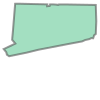

In [745]:
myGeomList[5]

Reading the Shapely documentation I see there is the unary_union function which should do exactly what I want. But when I try it I get the error below.

Apparently some of the shapes are not "valid".


In [746]:
unified_states = unary_union(myGeomList)

TopologyException: side location conflict at -119.99820178383436 41.992221793761161. This can occur if the input geometry is invalid.


ValueError: No Shapely geometry can be created from null value

Using Shapely's diagnostic tools I can see why:

In [13]:
for i in myGeomList:
    print(explain_validity(i))

Self-intersection[-88.1614025927057 34.9396324323625]
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Self-intersection[-95.7619971940279 40.5847991398333]
Self-intersection[-116.62253348324 45.7790886132876]
Valid Geometry
Valid Geometry
Self-intersection[-102.050597741394 40.002400002109]
Self-intersection[-89.5343439783832 36.4987064055471]
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Self-intersection[-91.7420256479018 40.6138690111907]
Valid Geometry
Valid Geometry
Valid Geometry
Self-intersection[-104.050098377583 48.9946000008568]
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Self-intersection[-119.998201783834 41.9922217937612]
Self-intersection[-79.7621 42.5143139672037]
Valid Geometry
Self-intersection[-103.005096909772 37.0003996581162]
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Valid Geometry
Self-intersection[-88.0641067624699 

There are several polygons which are "self-intersecting" and Shapely cannot make a single valid polygon out of them. If I access one of the invalid shapes it will be colored in red.

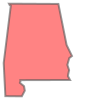

In [14]:
myGeomList[0]

In [15]:
print(myGeomList[0])

POLYGON ((-88.1955 35.0041, -85.6068 34.9918, -85.1756 32.8404, -84.8927 32.2593, -85.0342 32.1535, -85.1358 31.7947, -85.0438 31.52, -85.0836 31.3384, -85.107 31.2093, -84.9944 31.0023, -87.6009 30.9953, -87.5926 30.9423, -87.6256 30.8539, -87.4072 30.6745, -87.3688 30.4404, -87.524 30.1463, -88.3864 30.1546, -88.4743 31.8939, -88.1021 34.8938, -88.1721 34.9479, -88.1461 34.9107, -88.1955 35.0041))


Luckily, Shapely has a make_valid method for these cases.
And if I access the same shape after using this method, we can see it has created a multi-polygon by separating those self-intersecting lines into two polygons.

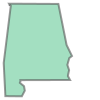

In [16]:
cleanList=[make_valid(x) for x in myGeomList]
cleanList[0]

In [17]:
print(cleanList[0])

MULTIPOLYGON (((-85.1756 32.8404, -84.8927 32.2593, -85.0342 32.1535, -85.1358 31.7947, -85.0438 31.52, -85.0836 31.3384, -85.107 31.2093, -84.9944 31.0023, -87.6009 30.9953, -87.5926 30.9423, -87.6256 30.8539, -87.4072 30.6745, -87.3688 30.4404, -87.524 30.1463, -88.3864 30.1546, -88.4743 31.8939, -88.1021 34.8938, -88.16140259270566 34.939632432362515, -88.1955 35.0041, -85.6068 34.9918, -85.1756 32.8404)), ((-88.1721 34.9479, -88.16140259270566 34.939632432362515, -88.1461 34.9107, -88.1721 34.9479)))


This is what it looks like if I join all of them:

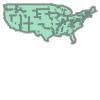

In [18]:
cu = unary_union(cleanList)
cu

And this is what the joint polygon looks like when mapped:

In [19]:
m = folium.Map([30.5454, -95.2627], zoom_start=2, tiles='cartodbpositron')
folium.GeoJson(cu,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)

m

The mapped polygon covers the majority of the territory, but there are clearly some gaps inbetween the states that we need to get rid of.

Luckily, Shapely has a constructive method called .buffer(**distance**).
It returns an approximate representation of all points within a given **distance** of the geometric object - and so with a minimal distance we eliminate those gaps entirely.

In [20]:
m = folium.Map([30.5454, -95.2627], zoom_start=2, tiles='cartodbpositron')
folium.GeoJson(cu.buffer(0.1),
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)

m

#### 2. Create evenly distributed points over that map which will be used to call the API .

Now we have exactly what we wanted, and we can start generating the coordinates of the evenly distributed points.
We use the buffered polygon and get the "bounds" - the min and max latitude and longitude.

From here we can create a range of points within the polygon with a certain resolution/density.

In [21]:
polygon=cu.buffer(0.1)
prep_polygon = prep(polygon)
latmin, lonmin, latmax, lonmax = polygon.bounds

In [22]:
resolution=2
points = []
for lat in np.arange(latmin, latmax, resolution):
    for lon in np.arange(lonmin, lonmax, resolution):
        points.append(Point((round(lat,4), round(lon,4))))



Now we want to add those points to our map:

In [23]:
polygon_points=polygon
polygon_points_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_points])

In [26]:
geo_points = []
for point in points:
    geo_points.append({"geometry": point})

# Use pandas.concat for concatenating the dataframes
polygon_points_gdf = pd.concat([polygon_points_gdf, pd.DataFrame(geo_points)], ignore_index=True)

In [25]:
polygon_points_gdf

geometry
0    POLYGON ((-124.34468 46.25440, -124.36765 46.4...
1                          POINT (-124.96790 24.29590)
2                          POINT (-124.96790 26.29590)
3                          POINT (-124.96790 28.29590)
4                          POINT (-124.96790 30.29590)
..                                                 ...
386                         POINT (-66.96790 40.29590)
387                         POINT (-66.96790 42.29590)
388                         POINT (-66.96790 44.29590)
389                         POINT (-66.96790 46.29590)
390                         POINT (-66.96790 48.29590)

[391 rows x 1 columns]

Before rendering this new geoDataFrame we need to set a CRS (coordinate reference system).

In [27]:
polygon_points_gdf.set_crs(epsg = "4326", inplace = True)

geometry
0    POLYGON ((-124.34468 46.25440, -124.36765 46.4...
1                          POINT (-124.96790 24.29590)
2                          POINT (-124.96790 26.29590)
3                          POINT (-124.96790 28.29590)
4                          POINT (-124.96790 30.29590)
..                                                 ...
776                         POINT (-66.96790 40.29590)
777                         POINT (-66.96790 42.29590)
778                         POINT (-66.96790 44.29590)
779                         POINT (-66.96790 46.29590)
780                         POINT (-66.96790 48.29590)

[781 rows x 1 columns]

In [33]:
m = folium.Map([20.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(polygon_points_gdf,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)

m

We can see that many of these points are outside our area, so we need to exclude them keeping only the ones inside.

In [34]:
# validate if each point falls inside shape using
# the prepared polygon
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))

In [39]:
polygon_points = polygon
polygon_points_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_points])
df_valid_points = gpd.GeoDataFrame({"geometry": valid_points})
polygon_points_gdf = pd.concat([polygon_points_gdf, df_valid_points], ignore_index=True)


/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [40]:
polygon_points_gdf.set_crs(epsg = "4326", inplace = True)
m = folium.Map([20.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(polygon_points_gdf,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)

m

Finally we have mapped those points within the borders of the continental US.

#### 3. From the result of the first scan, create circled areas centered at the evenly distributed points with a radius of the furthest away point using **distanceFromCurrent**.

Now we start making our first calls to the API to get the locations.
I'm making an array **initial_points** where I will store the **lat** and **lng** of each point and all the **locations** I collect from the calls made with that input.

In [42]:
initial_points=[]
for point in valid_points:
    point_dict={"lat":point.y, "lng":point.x,"locations":[]}
    initial_points.append(point_dict)


I also parse through the distances on each API call and collect the **maxDistance** values, and convert from miles into meters as **maxDistanceMeters**.

In [173]:
def get_locations(points):

    longitude=""
    latitude=""
    location_keys=["Center",
            "Address",
            "City",
            "State",
            "ZIP",
            "PhoneNumber",
            "Latitude",
            "Longitude",
            "Distance",
            "distanceFromCurrent",
            "order"
              ]
    for point in points:
        longitude=str(point["lng"])
        latitude=str(point["lat"])
        url="www.api_url/"+latitude +"/"+longitude+"/0/all"
        response=requests.get(url,headers=headers)
        time.sleep(1.5)
        for i in response.json():
            location_dict = { a_key: i[a_key] for a_key in location_keys }
            point["locations"].append(location_dict)

    currentDistances=[]
    maxDistance=""
    for point in points:
        currentDistances=[]
        for location in point["locations"]:
            currentDistances.append(float(location["distanceFromCurrent"]))
            maxDistance=max(currentDistances)
            point["maxDistance"]=maxDistance
    for point in points:
        point["maxDistanceMeters"] = 1609.34 * point["maxDistance"]   
    return points

In [57]:
initial_points = get_locations(initial_points)

This part could have probably been omitted, but knowing that a circle with a radius of x meters should not be perfectly round due to the distortions inherent in map projections (see: https://en.wikipedia.org/wiki/Tissot%27s_indicatrix), I was able to accurately shape the areas using azimuthal equidistant projection. 

The distortion is only noticeable closer to the poles, so the innacuracy could have been minimized by further reducing the radius of the circle made with **maxDistanceMeters**.

I used 90% of the maximum distance to create the areas to be conservative and be sure I was not missing any values at the same distance.

So here's the map with imperfect-perfect areas (before the accurate projection) and the area they cover:

In [58]:
m = folium.Map([20.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(polygon,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
for point in initial_points:
    folium.Circle([point["lat"],point["lng"]], radius=round(0.8*point["maxDistanceMeters"],2),fill_color="red", color="orange",fill_opacity=0.03, weight=0.3).add_to(m)
m

Next we create the more accurate projections. We use **WGS84** as the projection system because it is equivalent to our CRS EPSG Code (4326)

In [90]:
def accurate_projection(points):
    scanned_areas = []

    for point in points:
        lon, lat = point["lng"], point["lat"]
        radius = round(0.9 * point["maxDistanceMeters"], 2)
        local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lon)
        
        transformer_forward = pyproj.Transformer.from_crs(
            crs_from=pyproj.CRS('EPSG:4326'), 
            crs_to=pyproj.CRS(local_azimuthal_projection), 
            always_xy=True
        ).transform
        
        transformer_reverse = pyproj.Transformer.from_crs(
            crs_from=pyproj.CRS(local_azimuthal_projection), 
            crs_to=pyproj.CRS('EPSG:4326'), 
            always_xy=True
        ).transform

        center = Point(float(lon), float(lat))
        point_transformed = Point(*transformer_forward(center.x, center.y))
        buffer = point_transformed.buffer(radius)
        circle_poly_coords = transformer_reverse(*buffer.exterior.coords.xy)
        circle_poly = Polygon(list(zip(circle_poly_coords[0], circle_poly_coords[1])))
        
        scanned_areas.append(circle_poly)

    return scanned_areas

In [125]:
scanned_areas=accurate_projection(initial_points)

And here's an example of what a single mapped projection area will look like:

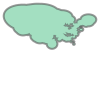

In [126]:
joined_circles = unary_union(scanned_areas)
joined_circles

 Above is the polygon as a result of joining the accurately mapped projections.
 
 Below we can see the same polygon that has been projected onto the map:

In [121]:
m = folium.Map([20.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(joined_circles,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

####  4. Make an intersection of the areas with the initial polygon (of the US).
Now if we map the difference between our polygon and the polygon of the US territory, we will get the unscanned gaps:

In [122]:
cutout_polygon=polygon.difference(joined_circles)
m = folium.Map([20.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(cutout_polygon,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

#### 5.Repeat the process over the leftover areas with a higher resolution (more densely-packed points) each time, until there is complete overlap between the areas and the initial polygon.
----

Initially, I believed I would only have to scan a couple of times to get all the area of the US, which is why I ended up repeating the code 3 times. If I had to do this again I would call the API and add points recursively, without passing through all these stages. But this is a good opportunity to have a visual representation of what is happening.

-----
I repeat the process again and reduce the resolution of the point (creating more points per unit of area)

In [110]:
def next_polygon(latmin, latmax, lonmin, lonmax, resolution, input_polygon):
    points = []
    for lat in np.arange(latmin, latmax, resolution):
        for lon in np.arange(lonmin, lonmax, resolution):
            points.append(Point((round(lat, 4), round(lon, 4))))

    # Validate if each point falls inside the shape using
    # the provided polygon
    valid_points = list(filter(input_polygon.contains, points))

    scanned_points = []
    for point in valid_points:
        point_dict = {"lat": point.y, "lng": point.x, "locations": []}
        scanned_points.append(point_dict)

    polygon = gpd.GeoDataFrame()
    polygon["geometry"] = gpd.GeoSeries(input_polygon)

    # Create a new dataframe for valid points and then concatenate
    df_valid_points = pd.DataFrame({"geometry": valid_points})
    polygon = pd.concat([polygon, df_valid_points], ignore_index=True)

    polygon.set_crs(epsg="4326", inplace=True)

    return polygon,scanned_points

In [111]:
polygon_second, second_scanned_points =next_polygon(latmin, latmax, lonmin, lonmax, 0.5, cutout_polygon)

/var/folders/yj/zlss9xn14gb77jp2bpq70l840000gp/T/ipykernel_57620/3339388482.py:17: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  polygon["geometry"] = gpd.GeoSeries(input_polygon)


In [112]:
polygon_second

geometry
0   MULTIPOLYGON (((-83.04197 42.04744, -83.02990 ...
1                         POINT (-117.96790 33.29590)
2                         POINT (-117.96790 33.79590)
3                         POINT (-117.46790 32.79590)
4                         POINT (-117.46790 33.29590)
..                                                ...
92                         POINT (-73.96790 39.79590)
93                         POINT (-73.96790 40.29590)
94                         POINT (-73.96790 40.79590)
95                         POINT (-73.46790 40.79590)
96                         POINT (-72.96790 40.79590)

[97 rows x 1 columns]

In [113]:
m = folium.Map([20.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(polygon_second,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=0.5),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

Now I call the API again using the coordinates of these points and generate the polygon given by our results, same as before.

In [127]:
second_scanned_points = get_locations(second_scanned_points)

In [132]:
second_scanned_areas = accurate_projection(second_scanned_points)

We join the polygon from the first scan with the second

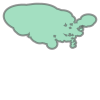

In [133]:
joint_scan=scanned_areas + second_scanned_areas
joined_scanned_areas = unary_union(joint_scan)
joined_scanned_areas

After cutting out the differences between the initial polygon and this one:

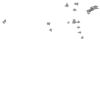

In [134]:
cutout_polygon2=polygon.difference(joined_scanned_areas)
cutout_polygon2

We generate points for this one (on an even lower resolution)

In [183]:

latmin, lonmin, latmax, lonmax = cutout_polygon2.bounds
third_points = []
for lat in np.arange(latmin, latmax, 0.03):
    for lon in np.arange(lonmin, lonmax, 0.03):
        third_points.append(Point((round(lat,4), round(lon,4))))

polygon_third, third_scanned_points = next_polygon(latmin, latmax, lonmin, lonmax, 0.1, cutout_polygon2)

/var/folders/yj/zlss9xn14gb77jp2bpq70l840000gp/T/ipykernel_57620/3339388482.py:17: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  polygon["geometry"] = gpd.GeoSeries(input_polygon)


In [184]:
m = folium.Map([25.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(polygon_third,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=0.5),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

And we repeat again.

In [185]:
third_scanned_points = get_locations(third_scanned_points)
third_scanned_areas = accurate_projection(third_scanned_points)

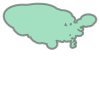

In [186]:
joint_scan3=scanned_areas + second_scanned_areas + third_scanned_areas
joined_scanned_areas3 = unary_union(joint_scan3)
joined_scanned_areas3

Now we are just left with very small areas on the map

In [187]:
cutout_polygon3=polygon.difference(joined_scanned_areas3)
m = folium.Map([25.5454, -95.2627], zoom_start=3, tiles='cartodbpositron')
folium.GeoJson(cutout_polygon3,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=1),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

For the last scan I use a resolution of 0.005, which generates many points considering that the bounds go from the polygon located in LA, to the polygons all the way East. Validating these points is very computationally expensive. It took around 18min on my laptop. If I had to redo it I would separate the multipolygon into individual polygons and then generate the points within each of their individual bounds.

In [210]:
polygon_fourth, fourth_scanned_points =next_polygon(latmin, latmax, lonmin, lonmax, 0.005, cutout_polygon3)

/var/folders/yj/zlss9xn14gb77jp2bpq70l840000gp/T/ipykernel_57620/3339388482.py:17: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  polygon["geometry"] = gpd.GeoSeries(input_polygon)


In [211]:
len(fourth_scanned_points)

755

And now we pack these points into the left-over areas

In [221]:
m = folium.Map([36.5454, -95.2627], zoom_start=3.5, tiles='cartodbpositron')
folium.GeoJson(polygon_fourth,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=0.5),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

We can zoom into an area for better visibility

In [213]:
m = folium.Map([39.9703, -75.1726], zoom_start=12, tiles='cartodbpositron')
folium.GeoJson(polygon_fourth,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=0.5),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

Last call to the API

In [214]:
fourth_scanned_points = get_locations(fourth_scanned_points)
fourth_scanned_areas = accurate_projection(fourth_scanned_points)

After joining the last areas of our scan, and getting the difference between that and our initial Polygon, which means that we no longer have any unscanned areas.

In [215]:
joint_scan4=scanned_areas + second_scanned_areas + third_scanned_areas + fourth_scanned_areas
joined_scanned_areas4 = unary_union(joint_scan4)
print(polygon.difference(joined_scanned_areas4))

POLYGON EMPTY


In [222]:
m = folium.Map([36.5454, -95.2627], zoom_start=3.5, tiles='cartodbpositron')
folium.GeoJson(joined_scanned_areas4,
               marker=folium.Circle(radius=4, fill_color="black", fill_opacity=0.4, color="black", weight=0.5),
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m

#### 6. Take all the locations I have from making the API calls, keep only the unique locations, clean the data and save to an Excel file.
In the meantime, we have been saving all the locations of our scan in 4 arrays. A single array object looks like the one below.

In [ ]:
flat_list = [location for points in [initial_points, second_scanned_points, third_scanned_points, fourth_scanned_points] for location in points["locations"]]
unique_dict = {}

for location in flat_list:
    unique_key = (location['Center'], location['Address'], location['City'], location['State'], location['ZIP'], location['PhoneNumber'], location['Latitude'], location['Longitude'])
    
    if unique_key not in unique_dict:
        unique_dict[unique_key] = location

# Extract the unique values
unique_list = list(unique_dict.values())

We create a dataframe from our list of unique objects where we can see 3170 locations

**Had to Hide it to anonimize the data**

In [ ]:
df = pd.DataFrame.from_dict(unique_list)

Finally, we save our dataframe as an Excel File

In [ ]:
df.to_excel('...directory/list_of_locations.xlsx')